In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import silhouette_score


In [136]:
reviews = pd.read_csv('reviews_final.csv')

In [137]:
products = pd.read_csv('products_final.csv')

In [138]:
products_from_clusters = pd.read_csv('products_recommended.csv')

# Clusterizamos clientes según KNN classifier

## Hacemos dummies de las variables categóricas

In [141]:
reviews_dummies = pd.get_dummies(
    reviews,
    columns = ['skin_tone', 'skin_type'],
    drop_first = True
)

In [142]:
reviews_dummies.columns

Index(['review_id', 'author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'submission_time', 'review_text', 'eye_color',
       'hair_color', 'product_id', 'brand_name', 'price_usd', 'numero_review',
       'cluster_product', 'skin_tone_light_to_medium',
       'skin_tone_medium_to_tan', 'skin_tone_very_light', 'skin_type_dry',
       'skin_type_normal', 'skin_type_oily'],
      dtype='object')

# Clusterizar clientes según KNN classifier

## Agrupar las reseñas por cliente

In [148]:
reviews_customers = reviews_dummies.groupby('author_id').agg({
    'rating': 'mean',  
    'price_usd': 'mean',
    'skin_tone_light_to_medium': 'mean',
    'skin_tone_medium_to_tan': 'mean',
    'skin_tone_very_light': 'mean',
    'skin_type_dry': 'mean',
    'skin_type_normal': 'mean',
    'skin_type_oily': 'mean'

}).reset_index()

## Calcular la proporción de cada cluster de producto por cliente

In [153]:
reviews_cluster_proportions = reviews_dummies.groupby('author_id')['cluster_product'].value_counts(normalize=True).unstack(fill_value=0)
# Obtener el clúster donde más se ha comprado (el clúster más frecuente para cada cliente)
reviews_cluster_proportions['most_frequent_cluster'] = reviews_cluster_proportions.idxmax(axis=1)
# Obtener el segundo clúster más frecuente
reviews_cluster_proportions['second_most_frequent_cluster'] = reviews_cluster_proportions.apply(lambda row: row.nlargest(2).idxmin(), axis=1)
# Mantener solo las columnas de los dos clústeres más frecuentes
reviews_cluster_proportions = reviews_cluster_proportions[['most_frequent_cluster', 'second_most_frequent_cluster']]
# Unir las dos nuevas columnas al dataset reviews_customers
reviews_customers = reviews_customers.merge(reviews_cluster_proportions, on='author_id', how='left')

## Definir las variables a usar en el clustering

In [174]:
variables_cluster = [
    'rating',
    'price_usd',
    'skin_tone_light_to_medium',
    'skin_tone_medium_to_tan',
    'skin_tone_very_light',
    'skin_type_dry',
    'skin_type_normal',
    'skin_type_oily',
    'most_frequent_cluster'
] 

# Crear el dataset final para clustering a nivel de cliente
reviews_cluster = reviews_customers[variables_cluster]

# Convertir todos los nombres de las columnas a tipo string
reviews_cluster.columns = reviews_cluster.columns.astype(str)
len(reviews_cluster.columns)

9

In [156]:
# Normalizar las variables numéricas para evitar que las escalas afecten el clustering
scaler = StandardScaler()
reviews_scaled = scaler.fit_transform(reviews_cluster)

# Usamos el método del codo y silhoutte score para elegir cuantos clusters usar

## Probamos con PCA

In [162]:
pca = PCA()
X_pca = pca.fit_transform(reviews_scaled)

In [164]:
# Varianza explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

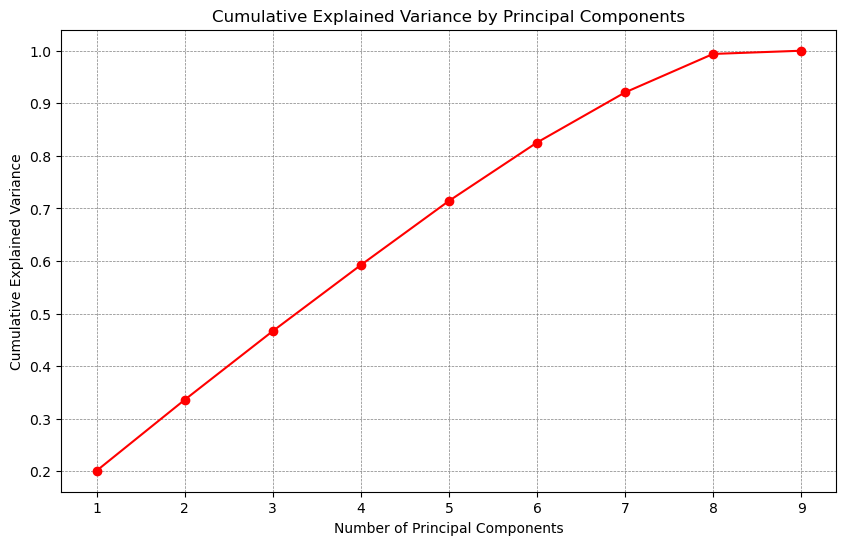

In [166]:
# Gráfico de varianza explicada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', color = 'red')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

## Método del codo y Silhouette Score

### Elegimos 6 PC según varianza explicada

In [176]:
pca = PCA(n_components=6) 
reviews_pca = pca.fit_transform(reviews_scaled)

In [178]:
inertia_values = []
silhouette_scores = []

# Probar con diferentes números de clústeres (por ejemplo, de 2 a 11)
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300, random_state=42)
    kmeans.fit(reviews_pca)
    
    # Guardar la inercia (WCSS)
    inertia_values.append(kmeans.inertia_)
    
    # Calcular el Silhouette Score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(reviews_pca, labels)
    silhouette_scores.append(silhouette_avg)

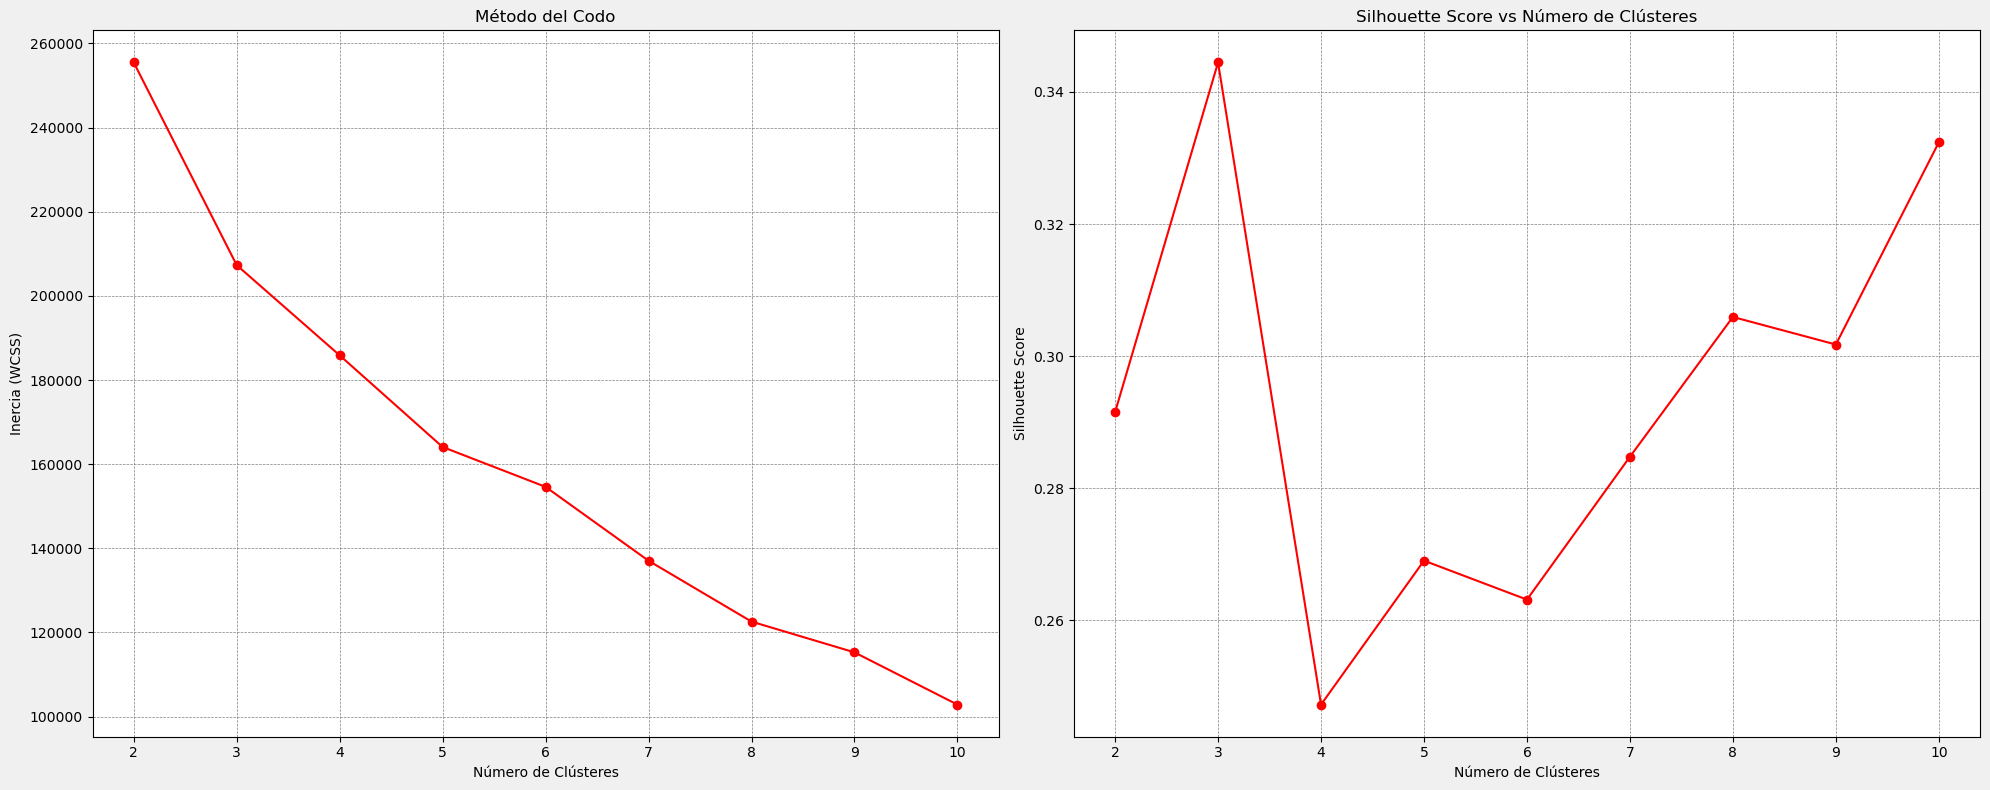

In [179]:
# Definir los colores personalizados
fondo_color_figura = '#F0F0F0'
fondo_color_ejes = '#FFFFFF'
line_color = 'red'
# Graficar el método del codo

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor(fondo_color_figura)
    
    # Gráfico del método del codo
ax1.set_facecolor(fondo_color_ejes)
ax1.plot(range(2, len(inertia_values) + 2), inertia_values, marker='o', color=line_color)
ax1.set_title('Método del Codo', color='black')
ax1.set_xlabel('Número de Clústeres', color='black')
ax1.set_ylabel('Inercia (WCSS)', color='black')
ax1.tick_params(colors='black')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5) 

    
    # Gráfico del Silhouette Score
ax2.set_facecolor(fondo_color_ejes)
ax2.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o', color=line_color)
ax2.set_title('Silhouette Score vs Número de Clústeres', color='black')
ax2.set_xlabel('Número de Clústeres', color='black')
ax2.set_ylabel('Silhouette Score', color='black')
ax2.tick_params(colors='black')
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5) 
    
plt.tight_layout()
plt.show()

## Sin PCA

In [182]:
# Encontrar el número óptimo de clústeres utilizando el método del codo y Silhouette Score
inertia_values = []
silhouette_scores = []

# Probar con diferentes números de clústeres (por ejemplo, de 2 a 11)
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300, random_state=42)
    kmeans.fit(reviews_scaled)
    
    # Guardar la inercia (WCSS)
    inertia_values.append(kmeans.inertia_)
    
    # Calcular el Silhouette Score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(reviews_scaled, labels)
    silhouette_scores.append(silhouette_avg)

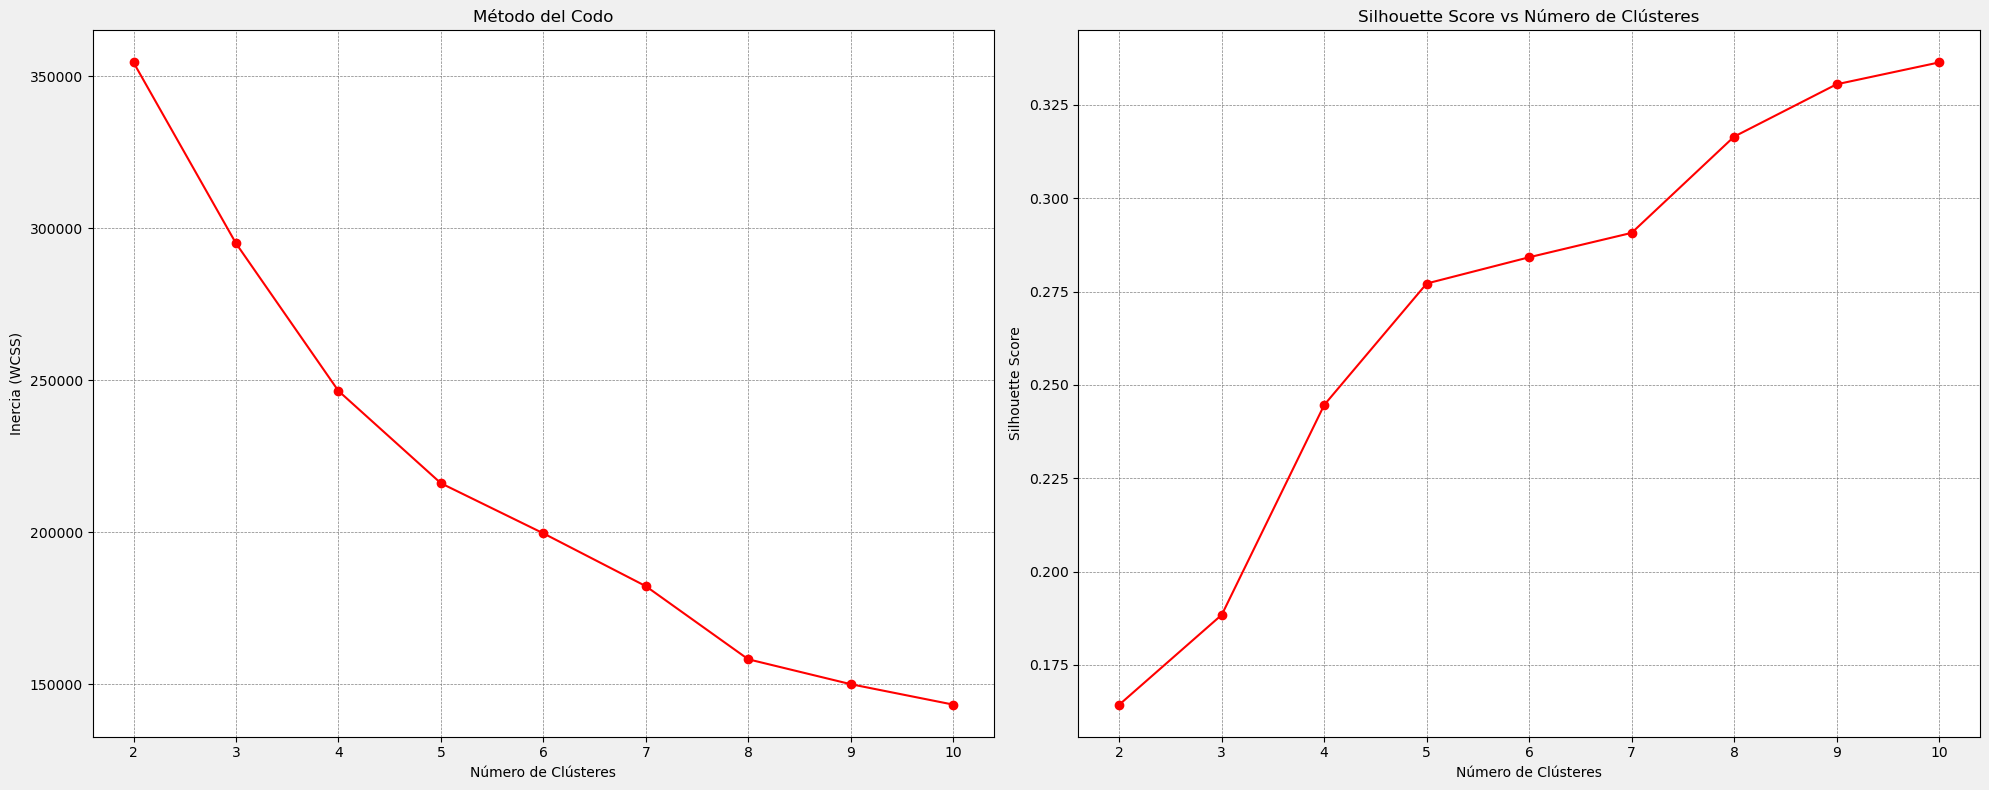

In [55]:
# Definir los colores personalizados
fondo_color_figura = '#F0F0F0'
fondo_color_ejes = '#FFFFFF'
line_color = 'red'
# Graficar el método del codo

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor(fondo_color_figura)
    
    # Gráfico del método del codo
ax1.set_facecolor(fondo_color_ejes)
ax1.plot(range(2, len(inertia_values) + 2), inertia_values, marker='o', color=line_color)
ax1.set_title('Método del Codo', color='black')
ax1.set_xlabel('Número de Clústeres', color='black')
ax1.set_ylabel('Inercia (WCSS)', color='black')
ax1.tick_params(colors='black')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)  

# Gráfico del Silhouette Score
ax2.set_facecolor(fondo_color_ejes)
ax2.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o', color=line_color)
ax2.set_title('Silhouette Score vs Número de Clústeres', color='black')
ax2.set_xlabel('Número de Clústeres', color='black')
ax2.set_ylabel('Silhouette Score', color='black')
ax2.tick_params(colors='black')
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)  

plt.tight_layout()
plt.show()

## Clusterizar a los clientes por Kmeans

In [102]:
kmeans_cluster_user = KMeans(n_clusters=8, random_state=42)
kmeans_cluster_user.fit(reviews_scaled)

KMeans(random_state=42)

In [104]:
labels = kmeans_cluster_user.labels_
silhouette_avg = silhouette_score(reviews_scaled, labels)

print("Silhouette Score sin PCA:", silhouette_avg)

Silhouette Score sin PCA: 0.31651713429885553


## Añadir los resultados del clustering al dataframe de clientes y dummie

In [106]:
reviews_customers['cluster_user'] = kmeans_cluster_user.labels_

In [107]:
reviews_customers.head(2)

,author_id,rating,price_usd,skin_tone_light_to_medium,skin_tone_medium_to_tan,skin_tone_very_light,skin_type_dry,skin_type_normal,skin_type_oily,most_frequent_cluster,second_most_frequent_cluster,cluster_user
0,51156.0,4.428571,33.670000,0.857143,0.0,0.142857,0.0,0.0,0.0,2,2,4
1,561736.0,5.000000,45.333333,0.000000,0.0,1.000000,0.0,0.0,0.0,2,2,3


In [111]:
reviews = reviews.merge(reviews_customers[['author_id', 'cluster_user']], on = 'author_id', how = 'left')

In [113]:
reviews.head(2)

,review_id,author_id,rating,is_recommended,helpfulness,total_feedback_count,submission_time,review_text,skin_tone,eye_color,skin_type,hair_color,product_id,brand_name,price_usd,numero_review,cluster_product,cluster_user_x,cluster_user_y
0,5,4.280257e+10,4,1.0,100.0,1,2023-03-19,The scent isn’t my favourite but it works grea...,light_to_medium,brown,normal,brown,P420652,LANEIGE,24.0,1,3,5.0,5.0
1,6,6.941884e+09,2,0.0,25.0,8,2023-03-19,I’ll give this 2 stars for nice packaging and ...,very_light,blue,combination,brown,P420652,LANEIGE,24.0,1,3,2.0,2.0


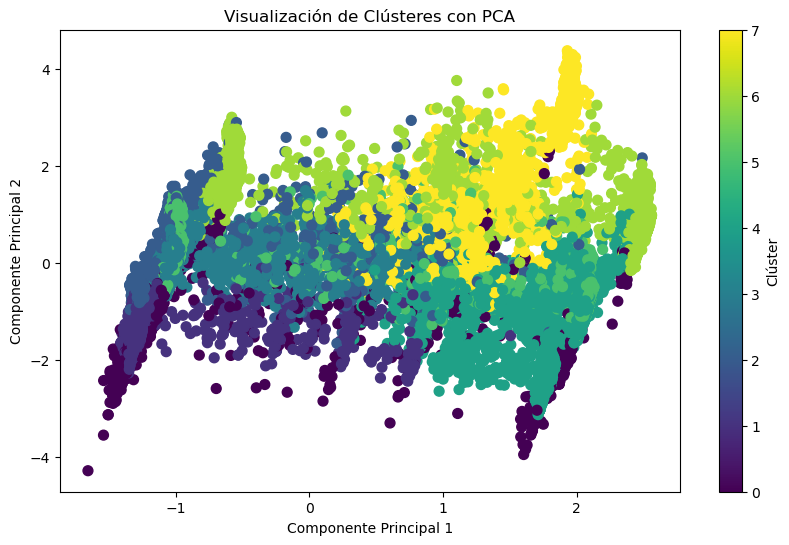

In [115]:
plt.figure(figsize=(10, 6))
plt.scatter(reviews_pca[:, 0], reviews_pca[:, 1], c=reviews_customers['cluster_user'], cmap='viridis', s=50)
plt.title('Visualización de Clústeres con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Clúster')
plt.show()

# Aplicar KNN-Nearest Neighbours

## Crear la matriz usuario-producto

In [119]:
pivot_table = reviews.pivot_table(
    values= "rating",
    index = "author_id",
    columns = "product_id",
    fill_value=0 #completa con ceros los na
)
pivot_table.head(2)

product_id,P107306,P114902,P12045,P122651,P122661,P122718,P122727,P122762,P122767,P122774,...,P54509,P6028,P7365,P7880,P91627362,P94421,P94812,P9939,P9940,P9941
author_id,,,,,,,,,,,,,,,,,,,,,
51156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
561736.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Aplicar modelo

In [122]:
model_neighbor = NearestNeighbors(
    n_neighbors= 5,
    metric = "cosine",
)
model_neighbor.fit(pivot_table)

NearestNeighbors(metric='cosine')

# Modelo de predicción del cluster KNN-Nearest Neighbours

In [81]:
# Seleccionar las características y el target (cluster)
customer_features = reviews_customers[variables_cluster]
customer_features.columns = customer_features.columns.astype(str)
target = reviews_customers['cluster_user']
# Entrenar un clasificador KNN
knn_classifier_user = KNeighborsClassifier(n_neighbors=5)
knn_classifier_user.fit(X, y)

NameError: name 'X' is not defined

# Función para predicción de cluster de nuevo usuario

In [ ]:
def get_cluster_newuser(new_user_data, knn_classifier_user, scaler, features_columns):
    new_user_dummies = pd.get_dummies(new_user_data)
    new_user_dummies = new_user_dummies.reindex(columns=features_columns, fill_value=0)
    new_user_scaled = scaler.transform(new_user_dummies)
    predicted_cluster = knn_classifier_user.predict(new_user_scaled)[0]
    return predicted_cluster

# Función de localización de los clusters de products según usuario

In [ ]:
def get_clusterproducts_users (nb_user, new_user_data=None):
    if nb_user in reviews['author_id'].values:
        clusters = reviews.loc[reviews['author_id'] == nb_user, 'cluster_product'].values
        if len(clusters) > 0:
            return list(clusters)
    elif nb_user == '0' and new_user_data is not None:
        predicted_cluster = get_cluster_newuser(new_user_data, knn_classifier, scaler, X.columns)
        print(f'El nuevo usuario pertenece al cluster: {predicted_cluster}') 
        return [predicted_cluster]
        return list(clusters)
    else:
        print('User not found')

# Localizacion de vecinos del nuevo usuario

In [ ]:
def get_neighbors_newuser(pivot_table, model_neighbor, n_neighbors=5):
    
    pivot_table.columns = pivot_table.columns.astype(str)
    
    new_user_ratings = pd.DataFrame([0] * pivot_table.shape[1]).T
    new_user_ratings.columns = pivot_table.columns
    
    pivot_with_new_user = pd.concat([pivot_table, new_user_ratings], ignore_index=True)
    
    pivot_with_new_user_np = pivot_with_new_user.to_numpy()
    
    _, vecinos = model_neighbor.kneighbors([pivot_with_new_user_np[-1]])  # Última fila = nuevo usuario

    neighbor_ids = vecinos[0, 1:]

    return neighbor_ids.tolist()


In [ ]:
def get_neighbors_existing_user(user_id, pivot_table, n_neighbors=5):
    
    pivot_table.columns = pivot_table.columns.astype(str) 
    user_row = pivot_table.loc[user_id].values.reshape(1, -1)  
    modelo = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    modelo.fit(pivot_table)
    _, vecinos = modelo.kneighbors(user_row)   
    neighbor_ids = pivot_table.index[vecinos[0, 1:]] 
    
    return neighbor_ids.tolist()

# Localización de los mejores productos por cluster de productos según usuario

In [307]:
def get_top_products_by_cluster(clusters, products_for_cluster, top_n=3):
    clusters = [int(cluster) for cluster in clusters]
    top_products = {}
    for cluster in clusters:
        cluster_products = products_for_cluster[products_for_cluster['cluster_product'] == cluster].sort_values(by= 'rating', ascending = False)
        top_cluster_products = cluster_products.head(top_n)
        top_products[cluster] = top_cluster_products
    return top_products
    

In [309]:

def recommend_from_neighbors(user_id, pivot_table, n_neighbors=5):
    modelo = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    modelo.fit(pivot_table.values)
    user_row = pivot_table.loc[user_id].values.reshape(1, -1) 
    _, vecinos = modelo.kneighbors(user_row)
    author_ids_vecinos = pivot_table.index[vecinos[0]]
    only_rating = pivot_table.iloc[vecinos[0], :].replace(0, np.nan).dropna(how='all', axis=1).dropna(how='all', axis=0)
    media_productos = only_rating.mean(axis=0)
    tabla_pedro = pivot_table.loc[user_id].to_frame(name='rating_real')
    tabla_pedro['recomendacion'] = media_productos
    recommendation_users = tabla_pedro[tabla_pedro['rating_real'] == 0].sort_values("recomendacion", ascending=False).head(10)
    
    return recommendation_users.index.tolist()

In [315]:

def recommend_products_for_user(user_id, pivot_table, new_user_data, n_neighbors, model_neighbor, knn_classifier_user, scaler):
    w = []
    if user_id == '0':
        if new_user_data is None:
            raise ValueError("Se requiere 'new_user_data' para un nuevo usuario.")
        predicted_cluster = get_cluster_newuser(new_user_data, knn_classifier_user, scaler, X.columns)
  
        neighbor_ids = get_neighbors_newuser(pivot_table, model_neighbor, n_neighbors)
  
        new_user_ratings = pd.Series([0] * pivot_table.shape[1], index=pivot_table.columns)
        pivot_table.loc['new_user'] = new_user_ratings
        from_neighbors = recommend_from_neighbors('new_user', pivot_table, n_neighbors=n_neighbors)
        w.extend(from_neighbors)
        pivot_table = pivot_table.drop(index='new_user')
    
    else:
        new_user_data = None
        neighbor_ids = get_neighbors_existing_user(user_id, pivot_table, n_neighbors=n_neighbors)
        from_neighbors = recommend_from_neighbors(user_id, pivot_table, n_neighbors=n_neighbors)
        w.extend(from_neighbors)
        for i in neighbor_ids:
            cluster_i = get_clusterproducts_users(i, new_user_data)
            if cluster_i:
                for j in cluster_i:
                    recommend_from_cluster = get_top_products_by_cluster([j], products_from_clusters, top_n=3)
                    for cluster, productss in recommend_from_cluster.items():
                        w.extend(productss['product_id'].tolist())  
    unique_w = list(set(w))

    if user_id != '0':
        productos_comprados = pivot_table.loc[user_id]
        productos_comprados = productos_comprados[productos_comprados > 0].index.tolist()  # Obtener los product_id con valor > 0
        productos_no_comprados = [product for product in unique_w if product not in productos_comprados]
    
    else:   
        productos_no_comprados = unique_w
    best = products[products['product_id'].isin(productos_no_comprados)][['product_id','product_name', 'rating','cluster_product']].sort_values(by='rating', ascending=False)
    
    return best


In [317]:
user_id = '0'
new_user_data = {
    'skin_tone': 'dark',
    'skin_type': 'oily'
}
n_neighbors = 5
best = recommend_products_for_user(
    user_id, 
    pivot_table, 
    new_user_data, 
    n_neighbors, 
    model_neighbor, 
    knn_classifier_user, 
    scaler
)
best

C:\Users\bigle\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\bigle\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,product_id,product_name,rating,cluster_product
2249,P442563,AHA 30% + BHA 2% Exfoliating Peeling Solution,4.5734,3
1438,P4010,AHA/BHA Exfoliating Cleanser,4.4981,9
1440,P471788,Mini AHA/BHA Exfoliating Cleanser,4.4898,11
807,P440312,Lotus Anti-Aging Night Moisturizer,4.4843,1
757,P447603,Ultra Repair Wild Oat Hydrating Toner,4.4746,12
2260,P427418,Granactive Retinoid* 2% Emulsion,4.4548,3
2033,P309308,Good Genes All-In-One AHA Lactic Acid Treatment,4.3375,3
874,P447791,Avocado Fine Line Eye Cream with Retinol,4.1087,17
2141,P408301,Purifying Pore & Blackhead Detox Mask,3.8450,2
2180,P481169,The Silk Sunscreen Mineral Broad Spectrum SPF ...,3.3975,14
